In [1]:
import pickle
import numpy as np
import os
import importlib.util
import matplotlib.pyplot as plt
#entailment
#diversity
#pronoun

In [15]:
args = {'sampler_path' : '/home/ubuntu/DialogRPT/data', \
        # 'sampler_path' : '/home/ubuntu/adversary_generator/test_conversations/contradiction', \
        # 'scorer_path' : '/home/ubuntu/dialogue_evaluation/', \
        'scorer_path' : '/home/ubuntu/DialogRPT/', \
        'randomize_data': False, \
        'all' : True, \
        'num_examples' : 10, \
        'background_examples': 100, \
        'e' : 'vocab', \
        'top_k' : 10, \
        'aggregate' : False, \
        'n_samples' : 1000, \
        'algo' : 'kernel', \
        'contains_response' : False,
        'sample_adversary' : False,
        'load_saved' : True,
        'metric_name' : "DialogRPT",
        'ds_name' : "daily_dialogue",
        'ds_type' : "test",
        'save_pickle' : True,
        'same_features' : False,
        'all_features' : True} #whether the input to the scorer is just the response (False) or response+context (True)
output_dir = os.path.join("./results", args["metric_name"], args["ds_name"])
print(f"This is the output directory:  {output_dir}")


This is the output directory:  ./results/DialogRPT/daily_dialogue


In [74]:
score_spec = importlib.util.spec_from_file_location("score", os.path.join(args["scorer_path"], "score.py"))
score = importlib.util.module_from_spec(score_spec)
score_spec.loader.exec_module(score)
# metric_name='context', mask_token='<|endoftext|>', ngrams=2 | these can be the input arguments to the daily dialogue evaluation scorer.
scorer = score.conversation_scorer(metric_name='overall', mask_token='<|endoftext|>', ngrams=2)

Loading Model: updown
Loading Model: width
Loading Model: depth
Loading Model: human-vs-rand


In [16]:
if args["sample_adversary"]:
    from sample_adversarial import adversary_sampler
    sampler = adversary_sampler(args["sampler_path"])
else:
    sample_spec = importlib.util.spec_from_file_location("sample", os.path.join(args["sampler_path"], "sample.py"))
    sample = importlib.util.module_from_spec(sample_spec)
    sample_spec.loader.exec_module(sample)
    sampler = sample.conversation_sampler(dataset_type=args["ds_type"])

In [17]:
def get_average_turns(sampler):
    turn_count = 0
    for conv in sampler.get_next():
        turn_count += len(conv.split('\n'))
    return turn_count/len(sampler)

def get_average_utterance_length(sampler):
    vocab_count = 0
    utt_count = 0
    for conv in sampler.get_next():
        for utt in conv.split('\n'):
            vocab_count += len(utt.split())
            utt_count += 1
    return vocab_count/utt_count

def get_unique_vocab_count(sampler):
    vocab = set()
    for conv in sampler.get_next():
        for utt in conv.split('\n'):
            vocab |= set([x for x in utt.split()])
    return len(vocab)

print(f"Number of Conversations: {len(sampler)}")
print(f"Average number of Turns: {get_average_turns(sampler)}")
print(f"Average utterance length: {get_average_utterance_length(sampler)}")
print(f"Unique vocabulary count: {get_unique_vocab_count(sampler)}")


Number of Conversations: 1000
Average number of Turns: 14.744
Average utterance length: 13.443773738469886
Unique vocabulary count: 8570


In [190]:
# scorer(['my name is baber'])
# for ix in range(len(sampler)//2):
ix = 15
print(sampler.candidate_conversations[(ix * 2)])
print("--------------")
print(sampler.candidate_conversations[(ix * 2) + 1])
print("--------------")
print(f"The score difference: {sampler.score_diffs[ix]}")
print(f"The original scores: {sampler.og_scores[ix]}")
print("Average metric scores for human conversations:", np.average([x[0] for x in sampler.og_scores]))
print("Average metric scores for adversarial conversations:", np.average([x[1] for x in sampler.og_scores]))
len(sampler)
# it = sampler.get_next()
# next(it)

What's his job ?
He used to be a policeman .
But Mrs.Smith hired him to find her lost son .
Yeah . He's a private eye now .
--------------
What's his job ?
He used to be a policeman .
But Mrs.Smith hired him to find her lost son .
He  did not use to be a policeman .
--------------
The score difference: 0.1970233703514896
The original scores: (0.1848362605076997, 0.3818596308591893)
Average metric scores for human conversations: 0.29106279281806297
Average metric scores for adversarial conversations: 0.3851728906452607


156

In [191]:
# f'{}_shap_values.pkl'
output_fname = f'{args["sampler_path"].split("/")[-1]}_shap_values.pkl'
output_fname

'contradiction_shap_values.pkl'

In [192]:
if args["load_saved"]:
    interpret_fp = os.path.join(output_dir, output_fname)
    with open(interpret_fp, "rb") as pshap_vals:
        shap_values = pickle.load(pshap_vals)

In [193]:
len(shap_values), len(sampler.candidate_conversations)

(156, 156)

In [80]:
def get_vocab_importance(args, importance_dict, shap_values, conversation=None, max_shap=-float('inf'), min_shap=float('inf')):
    # data_points

    if args['algo'] == 'kernel':
        shap_vals = shap_values.reshape((-1,))
        max_shap = max(max_shap, max(shap_vals))
        min_shap = min(min_shap, min(shap_vals))
        for i, data_point in enumerate(scorer.get_tokenizer().tokenize(conversation)):
            if data_point.startswith('Ġ'):
                data_point = data_point[1:]
            data_point = data_point.lower()

            importance_dict.setdefault(data_point, [])
            importance_dict[data_point].append(shap_vals[i])
    else:
        max_shap = max(max_shap, max(shap_values.values[0]))
        min_shap = min(min_shap, min(shap_values.values[0]))
        for i, data_point in enumerate(shap_values.data[0]):
            if data_point.startswith('Ġ'):
                data_point = data_point[1:].lower()
                
            importance_dict.setdefault(data_point, [])
            importance_dict[data_point].append(shap_values.values[0][i])

    return importance_dict, max_shap, min_shap

In [81]:
def get_normalized_avg_importance(vimportance, max_shap, min_shap):
    norm_imp_dict = dict()
    
    for word, vals in vimportance.items():
        norm_imp_dict[word] = np.average((np.array(vals) - min_shap)/(max_shap - min_shap))
    
    return norm_imp_dict

In [194]:
#aggregate importance over all the conversations
vimp_human = dict()
vimp_adv = dict()
max_shap = -float('inf')
min_shap = float('inf')
for ix in range(len(shap_values)):
    response = sampler.candidate_conversations[ix].split('\n')[-1]
    if ix % 2 == 0:
        vimp_human, max_shap, min_shap = get_vocab_importance(args, vimp_human, shap_values[ix], response, max_shap=max_shap, min_shap=min_shap)
    else:
        vimp_adv, max_shap, min_shap = get_vocab_importance(args, vimp_adv, shap_values[ix], response, max_shap=max_shap, min_shap=min_shap)

vimp_human_norm = get_normalized_avg_importance(vimp_human, max_shap, min_shap)
vimp_adv_norm = get_normalized_avg_importance(vimp_adv, max_shap, min_shap)

In [195]:
len(vimp_human_norm), len(vimp_adv_norm)

(535, 598)

In [196]:
# vimp_adv_norm
max_shap, min_shap

(0.1920331459620107, -0.05481756416365595)

In [14]:
def unroll_path(path):
    if len(path) == 0:
        return []
    return unroll_path(path[0]) + [path[1]] 

def get_feature_diff(vec1, vec2):
    matrix = [[0 for i in range(len(vec1))] for i in range(len(vec2))]
    path_matrix = [[tuple() for i in range(len(vec1))] for i in range(len(vec2))]
    overall_max = 0
    max_ix = (-1, -1)
    for i in range(len(vec2)):
        for j in range(len(vec1)):
            matched = int(vec2[i] == vec1[j])
            neighbors = [(0 if (i - 1 < 0) or (j - 1 < 0) else matrix[i-1][j-1]) + matched, 0 if (i - 1 < 0) else matrix[i-1][j], 0 if (j - 1 < 0) else matrix[i][j - 1]]
            chng_nbr_ix = [(1, 1), (1, 0), (0, 1)]
            matrix[i][j] = np.max(neighbors)
            max_nbr = np.argmax(neighbors)
            if max_nbr == 0 and matched == 1:
                path_matrix[i][j] = tuple((path_matrix[i-1][j-1], (i, j)))
            else:
                di, dj = chng_nbr_ix[max_nbr]
                path_matrix[i][j] = path_matrix[i - di][j - dj]
            if matrix[i][j] > overall_max:
                max_ix = (i, j)
                overall_max = matrix[i][j]
    max_ix = np.argmax(matrix)
    # print("The max index:", max_ix)
    max_row, max_col = max_ix // len(matrix[0]), max_ix % len(matrix[0])
    # print(max_row, max_col)
    # print(matrix[max_row][max_col])
    # print(path_matrix[max_row][max_col])
    to_ret = list(zip(*unroll_path(path_matrix[max_row][max_col])))
    if to_ret == []:
        return [], []
    return to_ret

In [197]:
i = 0
human_res = sampler.candidate_conversations[i].split('\n')[-1]
adv_res = sampler.candidate_conversations[i + 1].split('\n')[-1]
t = scorer.get_tokenizer()
vec1 = t.tokenize(human_res)
vec2 = t.tokenize(adv_res)

print(human_res, adv_res)
print(vec1, vec2)

feat2, feat1 = get_feature_diff(vec1, vec2)
# shap_values[i + 1][:len(feat2)], shap_values[i][:len(feat1)]
shap_values[i].reshape((-1,))[:len(vec1)], shap_values[i + 1].reshape((-1,))[:len(vec2)]

I work in marketing . I'm a regional marketing manager for an IT company . Normally , I work out of Beijing , but I'm here on business . My friend Judy over there , she lives here and she invited me to this party . And you ? How about you ? Hello , Michael . My name's Shirley . Pleased to  do not meet you .
['I', 'Ġwork', 'Ġin', 'Ġmarketing', 'Ġ.', 'ĠI', "'m", 'Ġa', 'Ġregional', 'Ġmarketing', 'Ġmanager', 'Ġfor', 'Ġan', 'ĠIT', 'Ġcompany', 'Ġ.', 'ĠNormally', 'Ġ,', 'ĠI', 'Ġwork', 'Ġout', 'Ġof', 'ĠBeijing', 'Ġ,', 'Ġbut', 'ĠI', "'m", 'Ġhere', 'Ġon', 'Ġbusiness', 'Ġ.', 'ĠMy', 'Ġfriend', 'ĠJudy', 'Ġover', 'Ġthere', 'Ġ,', 'Ġshe', 'Ġlives', 'Ġhere', 'Ġand', 'Ġshe', 'Ġinvited', 'Ġme', 'Ġto', 'Ġthis', 'Ġparty', 'Ġ.', 'ĠAnd', 'Ġyou', 'Ġ?', 'ĠHow', 'Ġabout', 'Ġyou', 'Ġ?'] ['Hello', 'Ġ,', 'ĠMichael', 'Ġ.', 'ĠMy', 'Ġname', "'s", 'ĠShirley', 'Ġ.', 'ĠP', 'leased', 'Ġto', 'Ġ', 'Ġdo', 'Ġnot', 'Ġmeet', 'Ġyou', 'Ġ.']


(array([ 0.0270541 ,  0.01586275, -0.01809391,  0.01161212, -0.01043886,
         0.        ,  0.0177678 , -0.01234896, -0.0166254 ,  0.01175586,
         0.02548783, -0.02368766,  0.        ,  0.        ,  0.0124794 ,
         0.01234654, -0.02891717,  0.01986759,  0.01041891,  0.        ,
         0.02379762,  0.02282055, -0.01197142, -0.0155659 , -0.00645878,
         0.02040356,  0.01544207,  0.02119464,  0.        ,  0.03338883,
         0.00825003, -0.01904601,  0.        ,  0.        ,  0.01977692,
         0.01823969, -0.01652874,  0.01282168, -0.00789223, -0.02004515,
         0.        ,  0.02074609,  0.03335039,  0.        ,  0.00407089,
         0.01982653,  0.02125918, -0.00979108,  0.        ,  0.        ,
         0.01685813,  0.00668406,  0.01332917,  0.        ,  0.        ]),
 array([0.1282069 , 0.01394094, 0.15043803, 0.04113137, 0.02584987,
        0.05007341, 0.00889985, 0.09339014, 0.02425736, 0.03846533,
        0.02585905, 0.04671793, 0.02045972, 0.04510371, 0.0

In [142]:
def normalize_vector(vec):
    return (vec - min(vec))/(max(vec) - min(vec))

In [143]:
def filter_prefix(token):
    return token[1:].lower() if token.startswith("Ġ") else token.lower()

In [163]:
args['all_features'] = False
args['same_features'] = False

In [164]:
# def get_disconnects(hum_feats, adv_feats):
    

In [198]:
def get_unmatched(vec, feat):
    to_ret = []
    for i in range(len(vec)):
        if i not in feat:
            to_ret.append(i)
    return to_ret

human_features = []
adv_features = []

mutated_feats = dict()

human_imps = []
adv_imps = []
for i in range(0, len(sampler.candidate_conversations), 2):
    human_res = sampler.candidate_conversations[i].split('\n')[-1]
    adv_res = sampler.candidate_conversations[i + 1].split('\n')[-1]
    t = scorer.get_tokenizer()

    vec1 = t.tokenize(human_res)
    vec2 = t.tokenize(adv_res)

    feat2, feat1 = get_feature_diff(vec1, vec2)

    if args['all_features']:
        hum_resp_feats, adv_resp_feats = [i for i in range(len(vec1))], [i for i in range(len(vec2))]
    elif args['same_features']:
        hum_resp_feats, adv_resp_feats = [x for x in feat1], [x for x in feat2]
    else:
        hum_resp_feats = get_unmatched(vec1, feat1)
        adv_resp_feats = get_unmatched(vec2, feat2)

    if len(hum_resp_feats) == 0 and len(adv_resp_feats) == 0:
        continue
    
    print(f"Case: {i}")
    print(human_res)
    print(adv_res)
    print("-------------------------------")
    print([vec1[x] for x in hum_resp_feats])
    print([vec2[x] for x in adv_resp_feats])
    print("###############################")
    
    hum_shap_vals = (shap_values[i].reshape((-1,)) - min_shap)/(max_shap - min_shap)
    adv_shap_vals = (shap_values[i + 1].reshape((-1,)) - min_shap)/(max_shap - min_shap)

    human_features.extend([vec1[i] for i in hum_resp_feats])
    adv_features.extend([vec2[i] for i in adv_resp_feats])

    cur_hum_imps = [hum_shap_vals[i] for i in hum_resp_feats]
    cur_adv_imps = [adv_shap_vals[i] for i in adv_resp_feats]

    over_hum_imp = 0 if len(cur_hum_imps) == 0 else sum(cur_hum_imps)
    over_adv_imp = 0 if len(cur_adv_imps) == 0 else sum(cur_adv_imps)

    human_imps.append(over_hum_imp)
    adv_imps.append(over_adv_imp)

Case: 0
I work in marketing . I'm a regional marketing manager for an IT company . Normally , I work out of Beijing , but I'm here on business . My friend Judy over there , she lives here and she invited me to this party . And you ? How about you ?
Hello , Michael . My name's Shirley . Pleased to  do not meet you .
-------------------------------
['I', 'Ġwork', 'Ġin', 'Ġmarketing', 'Ġ.', 'ĠI', "'m", 'Ġa', 'Ġregional', 'Ġmarketing', 'Ġmanager', 'Ġfor', 'Ġan', 'ĠIT', 'Ġcompany', 'Ġ.', 'ĠNormally', 'Ġ,', 'ĠI', 'Ġwork', 'Ġout', 'Ġof', 'ĠBeijing', 'Ġ,', 'Ġbut', 'ĠI', "'m", 'Ġhere', 'Ġon', 'Ġbusiness', 'Ġ.', 'ĠMy', 'Ġfriend', 'ĠJudy', 'Ġover', 'Ġthere', 'Ġ,', 'Ġshe', 'Ġlives', 'Ġhere', 'Ġand', 'Ġshe', 'Ġinvited', 'Ġme', 'Ġto', 'Ġthis', 'Ġparty', 'Ġ.', 'ĠAnd', 'Ġyou', 'Ġ?', 'ĠHow', 'Ġabout', 'Ġyou', 'Ġ?']
['Hello', 'Ġ,', 'ĠMichael', 'Ġ.', 'ĠMy', 'Ġname', "'s", 'ĠShirley', 'Ġ.', 'ĠP', 'leased', 'Ġto', 'Ġ', 'Ġdo', 'Ġnot', 'Ġmeet', 'Ġyou', 'Ġ.']
###############################
Case: 2
Yes .
 do 

In [166]:
np.average(human_imps), np.average(adv_imps)

(2.777665486457048, 4.019499226214271)

In [22]:
def bar_plot_features(human_features, adv_features, feature_names, xtitle, ytitle):
    total_width = 1.5
    start = 0.1
    bar_offset = 0.2
    human_coords = [start + ((total_width + bar_offset) * i) for i in range(len(human_features))]
    adv_coords = [start + (total_width/2) + ((total_width + bar_offset) * i) for i in range(len(human_features))]
    plt.bar(human_coords, human_features, width=total_width/2)
    plt.bar(adv_coords, adv_features, width=total_width/2)
    plt.xticks([coord - (total_width/3) for coord in adv_coords], feature_names)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.legend(["Human Use", "Adversarial Use"])

In [23]:
# human_features, adv_features

In [199]:
human_features = [y for y in set([filter_prefix(x) for x in human_features])]
adv_features = [y for y in set([filter_prefix(x) for x in adv_features])]
human_features.sort(key=lambda x: vimp_human_norm[x], reverse=True)
print(human_features[:args["top_k"]])
topk_hum_feats = []
count = 0

while count < len(human_features) and len(topk_hum_feats) < args["top_k"]:
    if human_features[count] in vimp_adv_norm:
        topk_hum_feats.append(human_features[count])
    count += 1
print(topk_hum_feats)

['fine', 'tea', 'nancy', 'exercise', 'may', 'name', 'montreal', 'speak', '59', 'mo']
['fine', 'tea', 'nancy', 'may', 'name', 'speak', '59', 'mo', 'authorized', "'ve"]


In [25]:
# vimp_adv_norm.keys(), vimp_human_norm.keys()

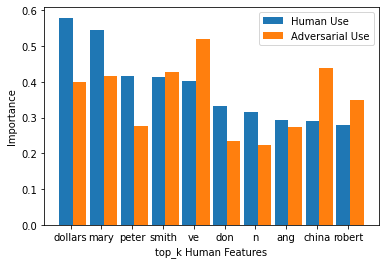

In [26]:
# human_features[:args["top_k"]]
[vimp_human_norm[x] for x in human_features[:args["top_k"]]]
bar_plot_features([vimp_human_norm[x] for x in topk_hum_feats], [vimp_adv_norm[x] for x in topk_hum_feats], \
    topk_hum_feats, "top_k Human Features", "Importance")

In [184]:
def plot_importance_as_bar(imp_labels, imp_vals, fig=None, axes=None, start_coord=0.0, \
    total_width=1.5, bar_offset=0.25, denominator=2, legend_labels=["Human Use", "Adversarial Use"]):

    print(f"Shape of importance values: {imp_vals.shape}")
    print(f"Tokens as plot labels: {imp_labels}")
    imp_labels = [filter_prefix(x) for x in imp_labels]
    x_coords = [start_coord + ((total_width + bar_offset) * i) for i in range(len(imp_vals))]
    if not axes:
        fig, ax = plt.subplots()
    else:
        ax = axes
    fig.set_size_inches(16, 8)
    
    ax.bar(x_coords, list(imp_vals), width=total_width/denominator)
    for i, word in enumerate(imp_labels):
        ax.text(x_coords[i], imp_vals[i]/2, word, rotation=90, fontsize=15)
    ax.set_ylabel("Importance [Normalized Shapley Values]", fontsize=15)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.legend(legend_labels, fontsize=15)
    return fig, ax

In [102]:
def collapse_features(tokens_vector, shap_vals):
    # print(len(tokens_vector))
    # print(shap_vals.shape[0])
    cur_shap_val = 0.0
    cur_token = ''
    cur_count = 0

    collapsed_tokens = []
    collapsed_shap_vals = []
    for i, token in enumerate(tokens_vector):
        if token.startswith('Ġ'):
            collapsed_tokens.append(cur_token)
            collapsed_shap_vals.append(cur_shap_val)
            
            cur_token = ''
            cur_shap_val = 0.0
            cur_count = 0
        cur_shap_val += shap_vals[i]
        cur_token += token
        cur_count += 1
    # print(f"Collapsed Tokens: {collapsed_tokens}")
    if len(cur_token) != 0:
        collapsed_tokens.append(cur_token)
        collapsed_shap_vals.append(cur_shap_val)
    return collapsed_tokens, np.array(collapsed_shap_vals)

In [201]:
plot_one = True
plot_original = False

Conversation No. 1:
Were you around when the robbery happened ?
Yes , I was .
Could you explain what you saw ?
I was in the bank at the time of the robbery .
What did you see ?
I saw a man come in with a gun .
Did you see his face ?
No . He had a mask on .
Conversation No. 2:
Were you around when the robbery happened ?
Yes , I was .
Could you explain what you saw ?
I was in the bank at the time of the robbery .
What did you see ?
I saw a man come in with a gun .
Did you see his face ?
I  did not see a man come in with a gun .
-------------------
['I', 'Ġ', 'Ġdid', 'Ġnot', 'Ġsee', 'Ġa', 'Ġman', 'Ġcome', 'Ġin', 'Ġwith', 'Ġa', 'Ġgun', 'Ġ.']
Shape of importance values: (13,)
Tokens as plot labels: ['I', 'Ġ', 'Ġdid', 'Ġnot', 'Ġsee', 'Ġa', 'Ġman', 'Ġcome', 'Ġin', 'Ġwith', 'Ġa', 'Ġgun', 'Ġ.']


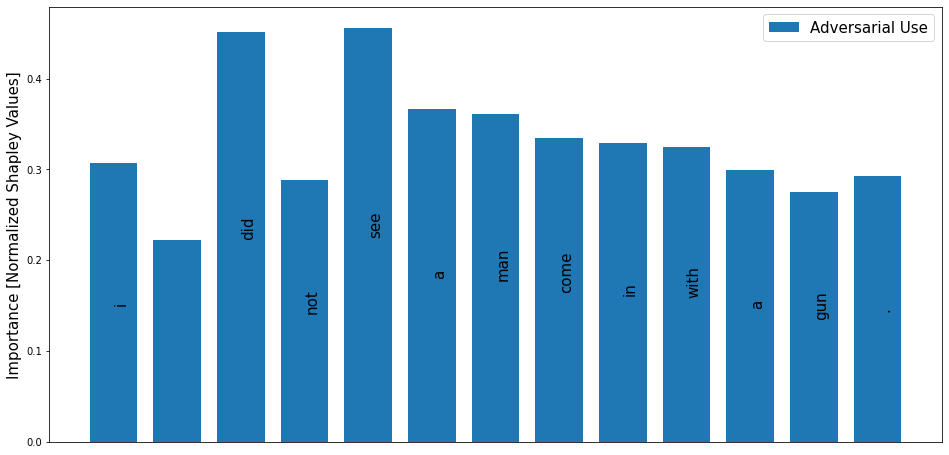

In [202]:
human_features = []
adv_features = []

mutated_feats = dict()

human_imps = []
adv_imps = []
#contradiction 130
#dullness 30
for i in range(130, len(sampler.candidate_conversations), 2):
    human_res = sampler.candidate_conversations[i].split('\n')[-1]
    adv_res = sampler.candidate_conversations[i + 1].split('\n')[-1]
    t = scorer.get_tokenizer()

    print("Conversation No. 1:")
    print(sampler.candidate_conversations[i])
    print("Conversation No. 2:")
    print(sampler.candidate_conversations[i + 1])

    vec1 = t.tokenize(human_res)
    vec2 = t.tokenize(adv_res)
    print("-------------------")
    print(vec2)

    feat2, feat1 = get_feature_diff(vec1, vec2)

    hum_resp_feats = get_unmatched(vec1, feat1)
    adv_resp_feats = get_unmatched(vec2, feat2)

    if len(hum_resp_feats) == 0 and len(adv_resp_feats) == 0:
        continue

    hum_shap_vals = (shap_values[i].reshape((-1,)) - min_shap)/(max_shap - min_shap)
    adv_shap_vals = (shap_values[i + 1].reshape((-1,)) - min_shap)/(max_shap - min_shap)
    
    max_len = max(len(vec1), len(vec2))

    feat_matrix = np.zeros((2, max_len))
    # feat_matrix = np.array([hum_shap_vals[:max_len], adv_shap_vals[:max_len]])
    for i in range(2):
        shap_vals, different_feats = (hum_shap_vals, hum_resp_feats) if i == 0 else (adv_shap_vals, adv_resp_feats)
        for ix in different_feats:
            feat_matrix[i][ix] = shap_vals[ix]

    if plot_one:
        total_width = 0.75
        denominator = 1
        legend_labels = ["Human Use"] if plot_original else ["Adversarial Use"]
    else:
        total_width = 1.5
        denominator = 2
        legend_labels = ["Human Use", "Adversarial Use"]

    fig, ax = plt.subplots()
    # denominator = 1
    if not plot_one or (plot_original and plot_one):
        fig, ax = plot_importance_as_bar(*collapse_features(vec1, hum_shap_vals[:len(vec1)]), fig=fig, axes=ax, \
            denominator=denominator, total_width=total_width, legend_labels=legend_labels)
    if not plot_one or (not plot_original and plot_one):
        fig, ax = plot_importance_as_bar(*collapse_features(vec2, adv_shap_vals[:len(vec2)]), fig=fig, axes=ax, total_width=total_width, \
            start_coord=((total_width/2) + 0.05), denominator=denominator, legend_labels=legend_labels)

    human_features.extend([vec1[i] for i in hum_resp_feats])
    adv_features.extend([vec2[i] for i in adv_resp_feats])

    cur_hum_imps = [hum_shap_vals[i] for i in hum_resp_feats]
    cur_adv_imps = [adv_shap_vals[i] for i in adv_resp_feats]

    over_hum_imp = 0 if len(cur_hum_imps) == 0 else sum(cur_hum_imps)
    over_adv_imp = 0 if len(cur_adv_imps) == 0 else sum(cur_adv_imps)

    human_imps.append(over_hum_imp)
    adv_imps.append(over_adv_imp)
    # plt.show()
    break

In [203]:
# output_dir, args["sampler_path"].split('/')[-1].strip()
specific_case = args["sampler_path"].split('/')[-1].strip()
if plot_one:
    subcat = "original" if plot_original else "adversarial"
    plot_path = os.path.join(output_dir, specific_case + f"_interpret_case_{subcat}.pdf")
else:
    plot_path = os.path.join(output_dir, specific_case + "_interpret_case.pdf")
fig.savefig(plot_path, format="pdf")
print(plot_path)

./results/DialogRPT/daily_dialogue/contradiction_interpret_case_adversarial.pdf


In [44]:
# feat_dicts = []
# for adv, features in enumerate([human_features, adv_features]):
#     import_dict = dict()
#     imps = human_imps if adv == 0 else adv_imps
#     for i, feat in enumerate(features):
#         feat = filter_prefix(feat)
#         # print(feat)
#         import_dict.setdefault(feat, (0, 0))
#         import_dict[feat] = (import_dict[feat][0] + imps[i], import_dict[feat][1] + 1)
#     feat_dicts.append({x: import_dict[x][0]/import_dict[x][1] for x in import_dict.keys()})

In [132]:
# import_dict['wait']

In [133]:
# hum_pairs = [(k, v) for k, v in feat_dicts[0].items()]
# adv_pairs = [(k, v) for k, v in feat_dicts[1].items()]
# hum_pairs.sort(key=lambda x: x[1], reverse=True)
# adv_pairs.sort(key=lambda x: x[1], reverse=True)
# hum_pairs[:args['top_k']], adv_pairs[:args['top_k']]